In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

In [1]:
# Load the file (adjust path if needed)
df = pd.read_csv("E:\\Walmart.csv")

# Preview structure
print(df.shape)
print(df.columns)
print(df.head())

(6435, 8)
Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')
   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  


In [5]:
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")

In [6]:
print(df.isnull().sum())

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [7]:
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.isocalendar().week
df["Year"] = df["Date"].dt.year
df["Day"] = df["Date"].dt.day

In [8]:
df = df.sort_values(["Store", "Date"])
df["Weekly_Sales_lag1"] = df.groupby("Store")["Weekly_Sales"].shift(1)
df["Weekly_Sales_roll4"] = df.groupby("Store")["Weekly_Sales"].transform(lambda x: x.rolling(4).mean())

In [9]:
scaler = StandardScaler()
scaled_cols = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
df[scaled_cols] = scaler.fit_transform(df[scaled_cols])

In [10]:
df.dropna(inplace=True)  # Remove rows with NaNs from lag/rolling
X = df.drop(columns=["Weekly_Sales", "Date"])
y = df["Weekly_Sales"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [12]:
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [13]:
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 43310.15
MAE: 30772.73


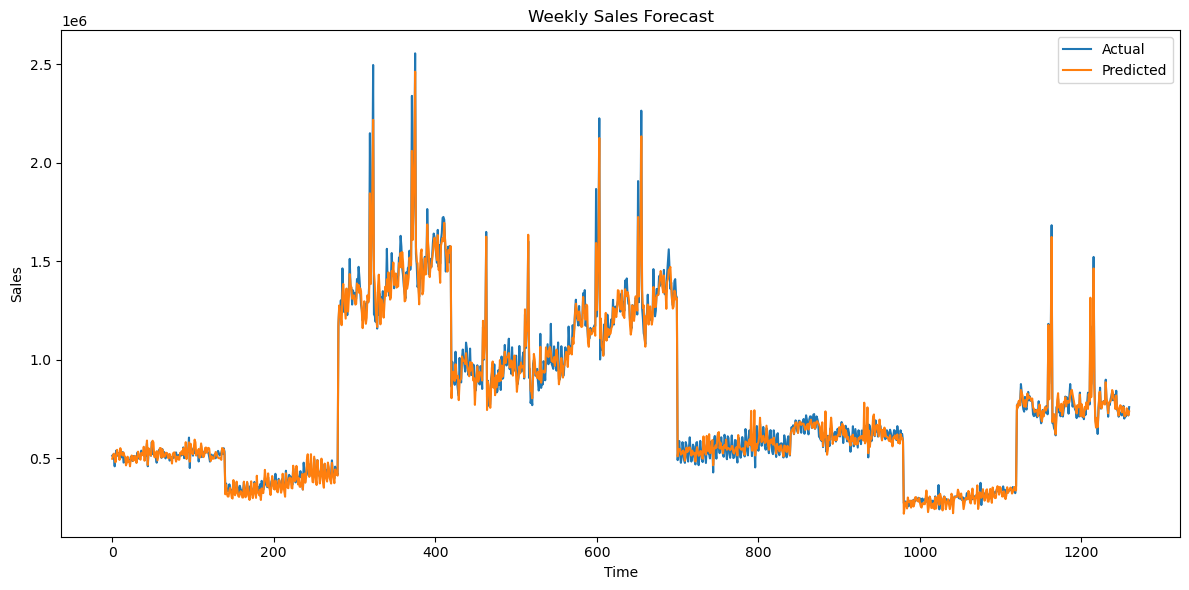

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Weekly Sales Forecast")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
df["Weekly_Sales_roll12"] = df.groupby("Store")["Weekly_Sales"].transform(lambda x: x.rolling(12).mean())

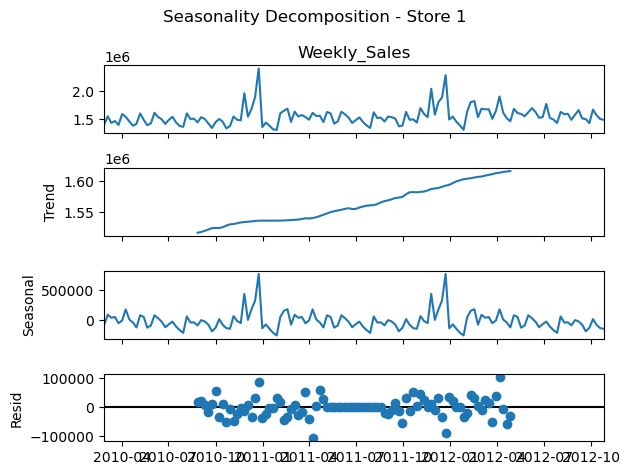

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Use one store's data for decomposition
store_sales = df[df["Store"] == 1].set_index("Date")["Weekly_Sales"]
result = seasonal_decompose(store_sales, model='additive', period=52)

result.plot()
plt.suptitle("Seasonality Decomposition - Store 1")
plt.tight_layout()
plt.show()

In [18]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

models = {
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(),
    "RandomForest": RandomForestRegressor()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")

XGBoost - RMSE: 43310.15, MAE: 30772.73
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1666
[LightGBM] [Info] Number of data points in the train set: 5040, number of used features: 12
[LightGBM] [Info] Start training from score 1116721.406824
LightGBM - RMSE: 42752.26, MAE: 29093.75
RandomForest - RMSE: 45808.08, MAE: 31669.05


In [19]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
xgb = XGBRegressor()
rmses = []

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    rmses.append(mean_squared_error(y_test, y_pred, squared=False))

print(f"TimeSeriesSplit RMSE (avg): {np.mean(rmses):.2f}")

TimeSeriesSplit RMSE (avg): 78737.30
